# Project 3: Percolation - FYS4460
Author: Øyvind Sigmundson Schøyen

In this project we'll explore _percolation_ from the project shown here: https://www.uio.no/studier/emner/matnat/fys/FYS4460/v19/notes/project2017-ob3.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spi
import skimage
import tqdm
import sklearn.linear_model
import seaborn as sns

sns.set(color_codes=True)

## Computing the density of spanning clusters

We call $P(p, L)$ the _density of spanning clusters._ It is defined as the probability for a site to belong to a _spanning cluster._ A spanning cluster is defined as a cluster having an extent over the entire system size along one axis. We compute the density by extracting all spanning clusters from a system and then counting all the set sites in the spanning clusters. Dividing the number of set sites contained in all the spanning clusters by the total number of sites we find $P(p, L)$.

In [2]:
def compute_density_of_spanning_clusters(system):
    num_rows, num_cols = system.shape
    total_mass = num_rows * num_cols

    # Label and count the number of connected clusters
    labels, num_features = spi.measurements.label(system)
    # Collect regions
    props = skimage.measure.regionprops(labels)
    num_percolating = 0
    mass = 0

    # Iterate through regions and check if they span the entire system
    for prop in props:
        min_row, min_col, max_row, max_col = prop.bbox

        if max_row - min_row == num_rows or max_col - min_col == num_cols:
            num_percolating += 1
            mass += prop.area

    return mass / total_mass, num_percolating

The function `compute_density_of_spanning_clusters` takes in a system and computes the density of spanning clusters, $P(p, L)$. It is general in the sense that it does not distinguish between quadratic or rectangular systems. Below we plot $P(p, L)$ for different $L$ and $p$.

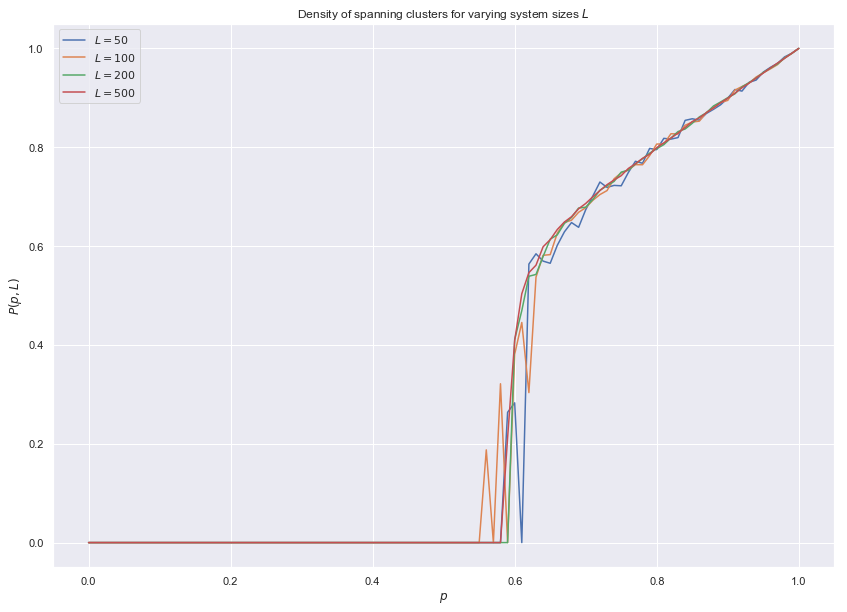

In [3]:
num_systems = 101
p_arr = np.linspace(0, 1, num_systems)
L_list = [50, 100, 200, 500]

plt.figure(figsize=(14, 10))

for L in L_list:
    density_arr = np.zeros_like(p_arr)
    pi_arr = np.zeros_like(p_arr)
    num_rows = L
    num_cols = L
    
    num_percolating_systems = 0

    for i in tqdm.tqdm_notebook(range(num_systems)):
        p = p_arr[i]
        system = np.random.choice([0, 1], size=(num_rows, num_cols), p=[1 - p, p])
        density_arr[i], num_percolating = compute_density_of_spanning_clusters(system)
        num_percolating_systems += num_percolating > 0

    plt.plot(p_arr, density_arr, label=fr"$L = {L}$")


plt.legend(loc="best")
plt.xlabel(r"$p$")
plt.ylabel(r"$P(p, L)$")
plt.title(r"Density of spanning clusters for varying system sizes $L$")
plt.show()

Here we can see the expected behaviour of the density of spanning clusters as a function of the probability $p$. At $p = p_c \approx 0.59$ the density increases almost step-wise before taking on a linear shape.

## Compute density of spanning clusters and spanning probability for a given system size $L$

We now want to create a function which can compute the density of spanning clusters $P(p, L)$ and the spanning probability $\Pi(p, L)$ for a given system size $L$. A way we can do this is by generating a system of size $L$. We can then vary the probability $p$ over a set range and mask the different sites. This lets us compute the density of spanning clusters and the spanning probability efficiently on a given system.

In [4]:
def compute_density_and_probability(system, p_arr):

    num_rows, num_cols = system.shape
    total_mass = num_rows * num_cols
    percolating = np.zeros(*p_arr.shape)
    mass = np.zeros(*p_arr.shape)

    for i, p in enumerate(p_arr):
        p_system = system < p

        # Label and count the number of connected clusters
        labels, num_features = spi.measurements.label(p_system)
        # Collect regions
        props = skimage.measure.regionprops(labels)

        # Iterate through regions and check if they span the entire system
        for prop in props:
            min_row, min_col, max_row, max_col = prop.bbox

            if max_row - min_row == num_rows or max_col - min_col == num_cols:
                percolating[i] += 1
                mass[i] += prop.area

    return mass / total_mass, percolating > 0

We now run $10$ experiments, that is regenerate a specific system $10$ times for every system, and find the percolation probability and density of the spanning clusters for systems with $L = 2, 4, 8, 16, 32, 64, 128, 256$.

In [5]:
p_arr = np.linspace(0, 1, 51)
num_experiments = 20

L_list = [2 ** (i + 1) for i in range(8)]
P_list = []
Pi_list = []

In [6]:
for L in L_list:
    P_mat = np.zeros((num_experiments, *p_arr.shape))
    Pi_mat = np.zeros_like(P_mat)

    for n in tqdm.tqdm_notebook(range(num_experiments)):
        system = np.random.random((L, L))
        P_mat[n], Pi_mat[n] = compute_density_and_probability(system, p_arr)

    P_list.append(np.average(P_mat, axis=0))
    Pi_list.append(np.average(Pi_mat, axis=0))

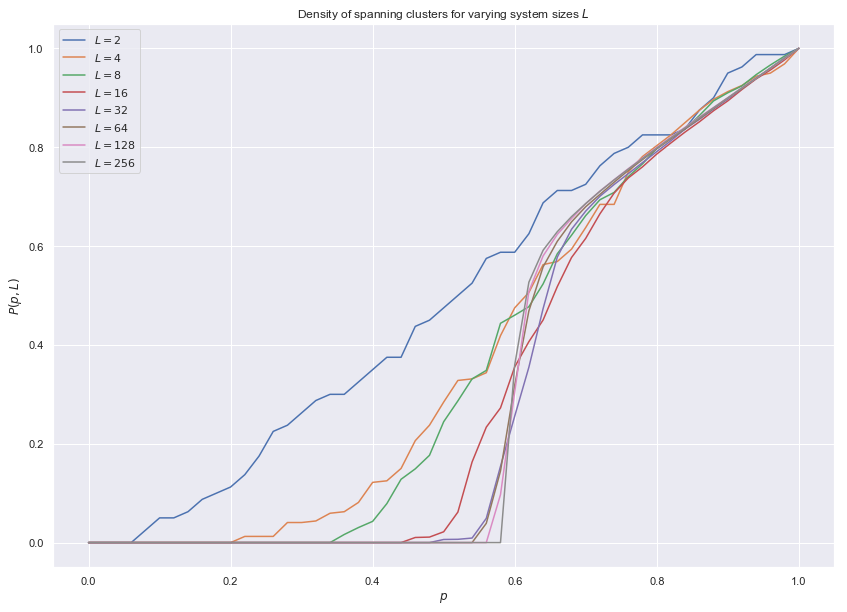

In [7]:
plt.figure(figsize=(14, 10))
for L, P in zip(L_list, P_list):
    plt.plot(p_arr, P, label=fr"$L = {L}$")

plt.xlabel(r"$p$")
plt.ylabel(r"$P(p, L)$")
plt.legend(loc="best")
plt.title(r"Density of spanning clusters for varying system sizes $L$")
plt.show()

Here we can see the density of spanning clusters for $L = 2, 4, 8, 16, 32, 64, 128, 256$. The trend shows that we start getting percolation around $p = p_c \approx 0.57$. We also see the characteristic logarithmic behaviour before density becomes more or less linear up to $p = 1$. We clearly see how an increase in system size makes the density exhibit more of expected behaviour.

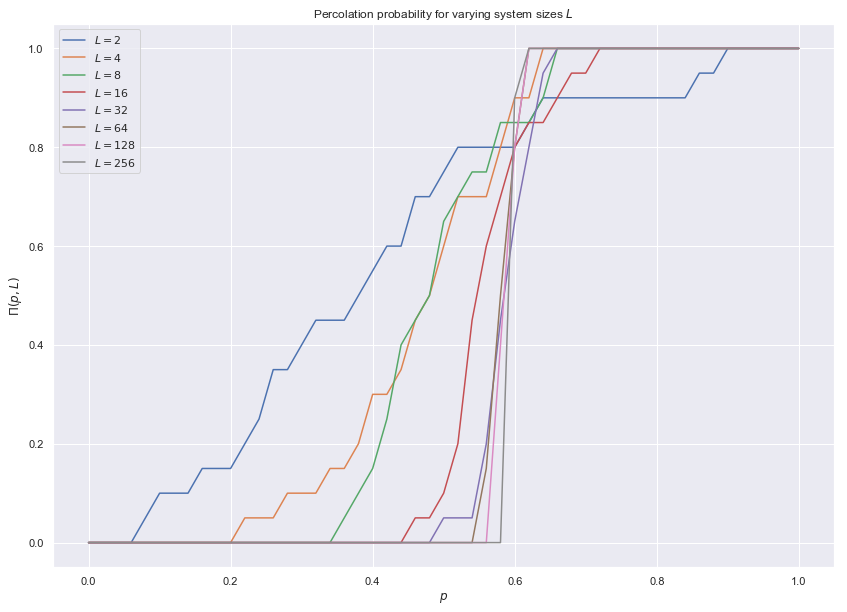

In [8]:
plt.figure(figsize=(14, 10))
for L, Pi in zip(L_list, Pi_list):
    plt.plot(p_arr, Pi, label=fr"$L = {L}$")

plt.legend(loc="best")
plt.xlabel(r"$p$")
plt.ylabel(r"$\Pi(p, L)$")
plt.title(r"Percolation probability for varying system sizes $L$")
plt.show()

This plot shows the percolation probability $\Pi(p, L)$ for $L = 2, 4, 8, 16, 32, 64, 128, 256$. We see much of the same behaviour as for the density of spanning clusters, that is, that $p_c \approx 0.57$, as this is where the largest system starts to percolate. Here we expect to see a step-function at $p = p_c$, and we can see that as the system increase, this behaviour is approximated well.

## Form of density of spanning cluster when $p > p_c$

We know that when $p > p_c$ we get
\begin{align}
    P(p, L) \propto (p - p_c)^{\beta}.
\end{align}
To find a value for $\beta$, we take the logarithm on both sides yielding
\begin{align}
    \log\Bigl[P(p, L)\Bigr] \propto \beta \log(p - p_c).
\end{align}
We can thus compute $\beta$ as the slope of the curve. For the approximate value of the critical percolation probability, we set $p_c = 0.59275$.

In [9]:
p_c = 0.59275 # Critical percolation probability
p_arr = np.linspace(p_c, 1, 101 + 1)[1:] # p > p_c

log_ppc = np.log(p_arr - p_c) # Dependent variable

In [10]:
P_list = []
Pi_list = []

for L in L_list:
    P_mat = np.zeros((num_experiments, *p_arr.shape))
    Pi_mat = np.zeros_like(P_mat)

    for n in tqdm.tqdm_notebook(range(num_experiments)):
        system = np.random.random((L, L))
        P_mat[n], Pi_mat[n] = compute_density_and_probability(system, p_arr)

    P_list.append(np.average(P_mat, axis=0))
    Pi_list.append(np.average(Pi_mat, axis=0))

For L = 64: beta = 0.2731901513759106
For L = 128: beta = 0.2600880265560061
For L = 256: beta = 0.24636904784319227


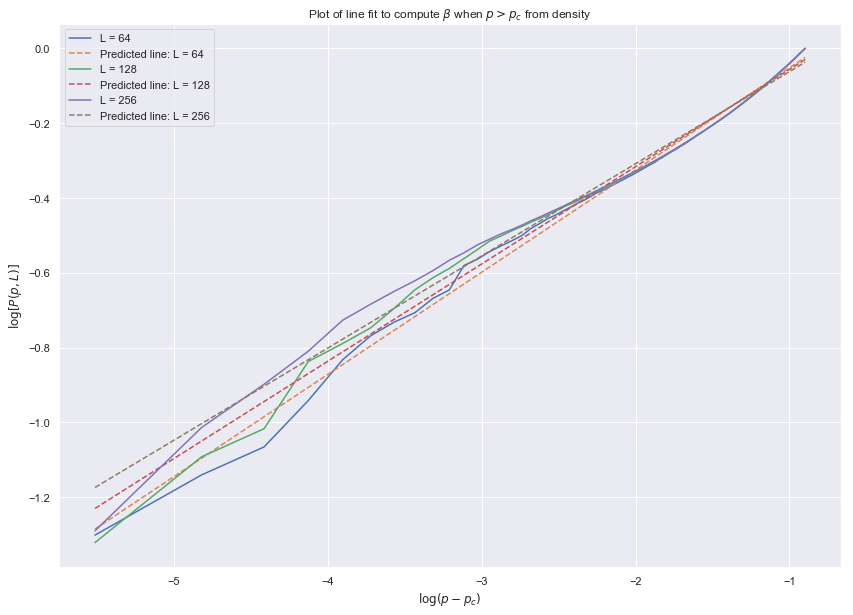

In [11]:
plt.figure(figsize=(14, 10))
for L, P in zip(L_list[-3:], P_list[-3:]):
    log_P = np.log(P)

    plt.plot(
        log_ppc,
        log_P,
        label=fr"L = {L}",
    )


    clf = sklearn.linear_model.LinearRegression(
        fit_intercept=True
    ).fit(log_ppc[:, None], log_P[:, None])

    beta = clf.coef_[0, 0]

    print(f"For L = {L}: beta = {beta}")

    plt.plot(
        log_ppc,
        clf.predict(log_ppc[:, None]).ravel(),
        "--",
        label=fr"Predicted line: L = {L}",
    )

plt.legend(loc="best")
plt.xlabel(r"$\log(p - p_c)$")
plt.ylabel(r"$\log[P(p, L)]$")
plt.title(r"Plot of line fit to compute $\beta$ when $p > p_c$ from density")
plt.show()

Here we can see log plots of the functional relation between the density of spanning clusters and the difference between the percolation probability and the critical probability when $p > p_c$. From the largest system size we find $\beta \approx 0.245$.